# Daily Streamflow from LOCA and BCSD for Gages II station data and 43 basins in Reclamation 2014

Plots of Exceedance probability

Variables include:
- Streamflow

In [1]:
%matplotlib inline

import os
import glob

import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')

obs_color = "#3498db"
hist_color = "#34495e"
rcp_color = "#e74c3c"

In [2]:
size = 'small'
# size = 'medium'
# size = 'large'
# size = 'huc070812'

# lookup = pd.read_csv(f'/glade/u/home/jvano/projects/LOCA_Downscaling_Analysis/lists/gageIInat_{size}.csv')  #commented out recently to make sure not used
# lookup = pd.read_csv('/glade/p/ral/hap/mizukami/loca/GF-loca12k/output/selected/gaugeII/gageIInat.csv')
# lookup = lookup.set_index('STAID')
# lookup.head()

# lookup_bor = pd.read_csv(f'/glade/u/home/jvano/projects/LOCA_Downscaling_Analysis/lists/basin_evaluated_table3_18.csv')
# lookup_bor = pd.read_csv(f'/glade/u/home/jvano/projects/LOCA_Downscaling_Analysis/lists/basin_evaluated_table3.csv')
lookup_bor = pd.read_csv(f'/glade/u/home/jvano/projects/LOCA_Downscaling_Analysis/lists/basin_evaluated_table3_short.csv')
lookup_bor = lookup_bor.set_index('Number')
lookup_bor.head()


,segid,Name,State,Latitude,Longitude
Number,,,,,
1,18002878,Williamson R. below Sprague River,OR,42.56,-121.84
5,18000492,Klamath River near Klamath,CA,41.51,-123.98


In [3]:
# huc_mapping = {'1': '1-2', '2': '1-2',
#                '3': '3',
#                '4': '4-6', '5': '4-6', '6': '4-6',
#                # ...
#                '9': '7-10',
#                '10L': '7-10', '10U': '7-10',
#                '11': '11-16', '12': '11-16', '13': '11-16', '14': '11-16', '15': '11-16', '16': '11-16',
#                '17': '17', '18': '18'}

def get_bcsd_df(seg, huc=None):
    if huc is None:
        huc_dir = '*'
    else:
        huc_dir = huc_mapping[huc]
        
    pattern = f'/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/gageIInat/{huc_dir}/*.routed.selected.nc'
    print(pattern, flush=True)
    files = glob.glob(pattern)
    index = xr.Variable('ens_member', ['_'.join(os.path.basename(f).split('.')[:2]) for f in files])
    ds = xr.open_mfdataset(files, concat_dim=index, data_vars='different')
    ds = ds.rename({'reachID': 'sSeg'}).set_coords('sSeg')

    df = ds.sel(sSeg=seg)['routedRunoff'].to_dataframe()
    df = df.drop(columns='sSeg')['routedRunoff'].unstack(level=0)
    return df


#JAV trying to get it to read in and understand Naoki's bor data
def get_bcsd_df_bor(seg, huc=None):
    if huc is None:
        huc_dir = '*'
    else:
        huc_dir = huc_mapping[huc]

#    pattern = f'/glade/p/ral/hap/mizukami/hydro_cmip5/vic/route/mizuRoute/route/output/selected/bor_cmip5_basin/*1.routed.selected.nc'
    pattern = f'/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc'
    print(pattern, flush=True)
    files = glob.glob(pattern)
    index = xr.Variable('ens_member', ['_'.join(os.path.basename(f).split('.')[:2]) for f in files])
    ds = xr.open_mfdataset(files, concat_dim=index, data_vars='different')
    ds = ds.rename({'reachID': 'sSeg'}).set_coords('sSeg')

    df = ds.sel(sSeg=row.segid)['routedRunoff'].to_dataframe()
    df = df.drop(columns='sSeg')['routedRunoff'].unstack(level=0)
    return df

# df = ds.sel(sSeg=10000541)['routedRunoff'].to_dataframe()
# df_bcsd = get_bcsd_df(row.seg_id2, huc=row.HUC02)

In [4]:
# gages II dataset
def get_loca_df(seg):
    files = glob.glob('/glade/p/ral/hap/mizukami/loca/GF-loca12k/output/selected/gaugeII/*.routed.selected.nc')
    index = xr.Variable('ens_member', ['_'.join(os.path.basename(f).split('.')[:2]) for f in files])
    ds = xr.open_mfdataset(files, concat_dim=index, data_vars='different')
    ds = ds.rename({'reachID': 'sSeg'}).set_coords('sSeg')

    df = ds.sel(sSeg=seg)['KWTroutedRunoff'].to_dataframe()
    df = df.drop(columns='sSeg')['KWTroutedRunoff'].unstack(level=0)
    return df

# 43 stations
def get_loca_df_bor(seg):
    files = glob.glob(f'/glade/p/ral/hap/jvano/loca/bor_cmip5_basin/*.routed.selected.nc')
    index = xr.Variable('ens_member', ['_'.join(os.path.basename(f).split('.')[:2]) for f in files])
    ds = xr.open_mfdataset(files, concat_dim=index, data_vars='different')
    ds = ds.rename({'reachID': 'sSeg'}).set_coords('sSeg')

    df = ds.sel(sSeg=seg)['KWTroutedRunoff'].to_dataframe()
    df = df.drop(columns='sSeg')['KWTroutedRunoff'].unstack(level=0)
    return df

In [5]:
def get_obs(siteno):
    strnum = str(siteno).zfill(9)
    df = pd.read_table(f'/glade/work/mizukami/data/streamflow_obs/{strnum}_streamflow_1980_leap.txt',
                       sep=r"\s*", header=None, names=['siteno', 'year', 'month', 'day', 'streamflow']).reset_index()
    
    df.index = pd.to_datetime({'year': df.year, 'month': df.month, 'day': df.day})
    df = df.drop(columns=['index', 'siteno', 'year', 'month', 'day'])
    return df * 0.028

In [6]:
def plotting_positions(n, alpha=0.4, beta=0.4):
    '''Returns a monotonic array of plotting positions.
    Parameters
    ----------
    n : int
        Length of plotting positions to return.
    alpha, beta : float
        Plotting positions parameter. Default is 0.4.
    Returns
    -------
    positions : ndarray
        Quantile mapped data with shape from `input_data` and probability
            distribution from `data_to_match`.
    See Also
    --------
    scipy.stats.mstats.plotting_positions
    '''
    return (np.arange(1, n + 1) - alpha) / (n + 1. - alpha - beta)

In [7]:
def make_fdc_data(df):
    pps = plotting_positions(len(df))
    vals = np.sort(df.values, axis=0)[::-1]
    return pd.DataFrame(data=vals, index=pps, columns=df.columns)

In [8]:
#df_bcsd
#make_fdc_data(df_bcsd).index

In [8]:
def make_figure_1(outfilename=None, name=None, huc=None):
#def make_figure_1(outfilename=None, name=None):
    
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 4))
    # Why not displaying?
    
    for i, (df, label) in enumerate([(df_bcsd, 'BCSD'), (df_loca, 'LOCA')]):
        plt.sca(axes[i])

        hist = make_fdc_data(df['1970': '1999'].filter(regex='rcp85'))
        rcp45 = make_fdc_data(df['2070': '2099'].filter(regex='rcp45'))
        rcp85 = make_fdc_data(df['2070': '2099'].filter(regex='rcp85'))

        lines0 = plt.plot(hist.index, hist.values, color=hist_color, lw=0.5, alpha=0.5, zorder=10)
#         lines1 = plt.plot(rcp45.index, rcp45.values, color=rcp_color, lw=0.5, alpha=0.5)
        lines2 = plt.plot(rcp85.index, rcp85.values, color=rcp_color, lw=0.5, alpha=0.5)
        plt.yscale('log')
        plt.ylim(ymax=np.percentile(df['1970': '1999'], 99.999) * 1.1, ymin=np.percentile(df['1970': '1999'], 0.0001) * .9)
        plt.xlabel('Exceedance probability')
        plt.ylabel('Streamflow ($m^3 s^{-1})$')
        plt.title(label)

    plt.figlegend((lines0[0], lines2[0]), ('Historical', 'RCP 8.5'))
        
    
    if name:
        fig.suptitle(f'{name}, in HUC02:{huc}', y=1.02)
    
    if outfilename is not None:
        fig.savefig(outfilename, bbox_inches='tight', dpi=300)

In [9]:
def make_figure_2(outfilename=None, name=None, huc=None):

    fig, axes = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(12, 8))

    lines = []
    labels = []

    plt.sca(axes)
    obs = make_fdc_data(df_obs['1970': '1999'])
    obs_line = plt.plot(obs.index, obs.mean(axis=1).values, color=obs_color, lw=4, zorder=10, ls='-',)
    lines.append(obs_line[0])
    labels.append('Observations')

    for i, (df, label) in enumerate([(df_bcsd, 'BCSD'), (df_loca, 'LOCA')]):

        if i == 1:
            ls = '--'
        else:
            ls = '-'

        hist = make_fdc_data(df['1970': '1999'].filter(regex='rcp85'))
        rcp85 = make_fdc_data(df['2070': '2099'].filter(regex='rcp85'))

        lines0 = plt.plot(hist.index, hist.mean(axis=1).values, color=hist_color, lw=2, zorder=10, ls=ls)
    #     lines1 = plt.plot(rcp45.index, rcp45.mean(axis=1).values, color='orange', lw=2, ls=ls)
        lines2 = plt.plot(rcp85.index, rcp85.mean(axis=1).values, color=rcp_color, lw=2, ls=ls)
        plt.yscale('log')
        plt.xlabel('Exceedance probability')
        plt.ylabel('Streamflow ($m^3 s^{-1})$')

        lines.extend([lines0[0], lines2[0]])
        labels.extend([f'{label}-Historical', f'{label}-RCP 8.5'])

    plt.figlegend(lines, labels, loc='upper right')

    if name:
        plt.title(f'{name}, in HUC02:{huc}')
    
    if outfilename is not None:
        fig.savefig(outfilename, bbox_inches='tight', dpi=300)

In [10]:
def make_figure_3(outfilename=None, name=None, state=None):
#def make_figure_1(outfilename=None, name=None):
    
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 4))
    # Why not displaying?
    
    for i, (df, label) in enumerate([(df_bcsd, 'BCSD'), (df_loca, 'LOCA')]):
        plt.sca(axes[i])

        hist = make_fdc_data(df['1970': '1999'].filter(regex='rcp85'))
        rcp45 = make_fdc_data(df['2070': '2099'].filter(regex='rcp45'))
        rcp85 = make_fdc_data(df['2070': '2099'].filter(regex='rcp85'))

        lines0 = plt.plot(hist.index, hist.values, color=hist_color, lw=0.5, alpha=0.5, zorder=10)
        lines1 = plt.plot(rcp45.index, rcp45.values, color=obs_color, lw=0.5, alpha=0.5)
        lines2 = plt.plot(rcp85.index, rcp85.values, color=rcp_color, lw=0.5, alpha=0.5)
        plt.yscale('log')
        plt.ylim(ymax=np.percentile(df['1970': '1999'], 99.999) * 1.1, ymin=np.percentile(df['1970': '1999'], 0.0001) * .9)
        plt.xlabel('Exceedance probability')
        plt.ylabel('Streamflow ($m^3 s^{-1})$')
        plt.title(label)

    plt.figlegend((lines0[0], lines1[0], lines2[0]), ('Historical', 'RCP 4.5', 'RCP 8.5'))
         
    if name:
        fig.suptitle(f'{name}, {state}', y=1.02)
    
    if outfilename is not None:
        fig.savefig(outfilename, bbox_inches='tight', dpi=300)      

In [11]:
display (lookup_bor)
# display (row)

,segid,Name,State,Latitude,Longitude
Number,,,,,
1,18002878,Williamson R. below Sprague River,OR,42.56,-121.84
5,18000492,Klamath River near Klamath,CA,41.51,-123.98


In [12]:
def joint_ax_lims(axes):
    low, high = axes[0].get_ylim()
    for ax in axes[1:1]:
        low2, high2 = ax.get_ylim()
        low = min(low, low2)
        high = max(high, high2)
    for ax in axes:
        ax.set_ylim(low, high)

In [ ]:
# COMBINED FIGURE, IN MAINTEXT AND APPENDIX

#TODO set axis based on RCP 8.5 values (see how did it with HUCs)

rcp = 'rcp85'  #TODO need - but don't really understand why for: filter(regex=f'{rcp}') - doesn't work to replace with scen

# plots = 'maintext'
# plots = 'appendix1-8'
# plots = 'appendix9-16'
# plots = 'appendix17-24'
plots = 'appendix25-32'
# plots = 'appendix33-40'
# plots = 'appendix41-43'

cfsconv = 35.3147

nrows = 8
y = 0.95
if plots == 'maintext':
    nrows = 7
    y = 0.96
if plots == 'appendix41-43':
    nrows = 3
    y = 1.03

make_fig = True
if make_fig:
    
    loca_color = "#3498db"
    loca_hist_color = "#34495e"
    bcsd_color = "#e73cac"
    bcsd_hist_color = "#e46725"

    obs_color = "#3498db"
    hist_color = "#34495e"
    rcp_color = "#e74c3c"
    
    ncols = 3
    scale = 'all'  #could be: high10, low10, all

    lookup_bor = pd.read_csv(f'/glade/u/home/jvano/projects/LOCA_Downscaling_Analysis/lists/basins_fig_{plots}.csv')
    lookup_bor = lookup_bor.set_index('Number')

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, figsize=(ncols*5, 23 * nrows/7), squeeze=False)
#     fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(ncols*5, 23), squeeze=False)  #sets y axis the same

    for i, (staid, row) in enumerate(lookup_bor.iterrows()):
        for j, scen in enumerate(['hist', 'rcp45', 'rcp85']):

            print(f'reading {scen}')
            plt.sca(axes[i, j])

            if 'rcp' in scen:
                rcploca = make_fdc_data(dfloca['2070': '2099'].filter(regex=scen))
                rcpbcsd = make_fdc_data(dfbcsd['2070': '2099'].filter(regex=scen))
            else:
                dfloca = get_loca_df_bor(row.segid)
                dfbcsd = get_bcsd_df_bor(row.segid, huc=None)
                histloca = make_fdc_data(dfloca['1970': '1999'].filter(regex=f'{rcp}'))
                bcsd_scen = 'rcp45' if 'hist' in scen else scen
                histbcsd = make_fdc_data(dfbcsd['1970': '1999'].filter(regex=f'{bcsd_scen}'))
            if scen == 'hist':                
                lines0 = plt.plot(histloca.index, histloca.values * cfsconv, color=loca_hist_color, lw=0.5, alpha=0.5, zorder=10)
                lines1 = plt.plot(histbcsd.index, histbcsd.values * cfsconv, color=bcsd_hist_color, lw=0.5, alpha=0.5, zorder=10)
                if i == 0:
                    leg = plt.legend((lines0[0], lines1[0]), ('LOCA', 'BCSD'),  fontsize=18)
                    for line in leg.get_lines():
                        line.set_linewidth(4)
                        
            if 'rcp' in scen:
                lines2 = plt.plot(rcploca.index, rcploca.values * cfsconv, color=loca_color, lw=0.5, alpha=0.5)
                lines3 = plt.plot(rcpbcsd.index, rcpbcsd.values * cfsconv, color=bcsd_color, lw=0.5, alpha=0.5)
                if i == 0:
                    leg = plt.legend((lines2[0], lines3[0]), ('LOCA', 'BCSD'),  fontsize=18)
                    for line in leg.get_lines():
                        line.set_linewidth(4)

            plt.yscale('log')
            if j == 0:
#                 plt.ylabel(f'{row.Name}', fontsize=13)  #adding it to access.  didn't fit well.
                plt.ylabel('cfs', fontsize=18)
#             plt.ylim([.1, 20000 * cfsconv]) 
            if (scale == 'high10'):
                plt.xlim([0, .1])  
                plt.ylim([.5, 30000 * cfsconv]) 
            if (scale == 'low10'):
                plt.xlim([0.9, 1.0])
            if j == 1:

                plt.xlabel(f'{row.Name}', fontsize=20, rotation='horizontal', labelpad=10)
                
#                 https://stackoverflow.com/questions/51759859/how-to-move-labels-from-bottom-to-top-without-adding-ticks
                ax = axes[i, j]
                ax.xaxis.set_label_position('top')  

#                 other attempts to adding text to right of fig:
#                 plt.suptitle(f'{row.Name}', fontsize=30)
#                 plt.text(0, 100, f'{row.Name}', fontsize=24)
#                 ax.yaxis.tick_right()
#                 plt.text(3, 8, f'{row.Name}', style='italic', fontsize=24, bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#                 ax.xaxis.set_label_position('top')
#                 ax.xaxis.get_ticks_position()
#                 plt.yticks(rotation=0)
#                 ax.xaxis.tick_top() # x axis on top                      

#                 ax.xaxis.set_label_position('top')
#                 ax.xaxis.tick_top()  #moves ticks
#                 ax.xaxis.set_label_position('top')  #http://desk.stinkpot.org:8080/tricks/index.php/2011/07/move-x-axis-label-to-top-of-figure-in-matplotlib/

    
            if i == 0:
                headername = {'hist': 'Historical', 'rcp45': 'RCP 4.5', 'rcp85': 'RCP 8.5'}
                ax = axes[i, j]
                ax.set_title(headername[scen], fontsize=28, y=1.2)
                
        joint_ax_lims(axes[i, :3])
                
    fig.suptitle('Exceedance probability', fontsize=30, y=y)
    fig.subplots_adjust(hspace=.35)
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/fdc_ensemble_bor_{scale}_{plots}.png', bbox_inches='tight', dpi=300)

reading hist
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp45
reading rcp85
reading hist
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp45
reading rcp85
reading hist
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp45
reading rcp85
reading hist
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp45
reading rcp85
reading hist
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp45
reading rcp85
reading hist
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp45
reading rcp85
reading hist
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp45
reading rcp85
reading hist
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp45
reading rcp85


In [21]:
# ALL BASINS ON A SINGLE FIG - BUT EITHER HISTORICAL, RCP4.5, RCP8.5  (DID NOT USE IN REPORT)

make_fig = False
if make_fig:
    
    loca_color = "#3498db"
    loca_hist_color = "#34495e"
    bcsd_color = "#e73cac"
    bcsd_hist_color = "#e46725"

    obs_color = "#3498db"
    hist_color = "#34495e"
    rcp_color = "#e74c3c"
    
    scale = 'all'  #high10, low10, all

    lookup_bor = pd.read_csv(f'/glade/u/home/jvano/projects/LOCA_Downscaling_Analysis/lists/basin_evaluated_table3.csv')
    lookup_bor = lookup_bor.set_index('Number')

    fig, axes = plt.subplots(ncols=6, nrows=8, sharex=True, sharey=True, figsize=(30, 10*4), squeeze=False)

    period = 'hist' #fut, hist, hist_fut
    # rcp = 'rcp45'
    rcp = 'rcp85'

    for i, (staid, row) in enumerate(lookup_bor.iterrows()):

        plt.sca(axes.flat[i])
        dfloca = get_loca_df_bor(row.segid)
        histloca = make_fdc_data(dfloca['1970': '1999'].filter(regex=f'{rcp}'))
        dfbcsd = get_bcsd_df_bor(row.segid, huc=None)
        histbcsd = make_fdc_data(dfbcsd['1970': '1999'].filter(regex=f'{rcp}'))
        
        if (rcp == 'rcp85'):
            rcp85loca = make_fdc_data(dfloca['2070': '2099'].filter(regex='rcp85'))
            rcp85bcsd = make_fdc_data(dfbcsd['2070': '2099'].filter(regex='rcp85'))
            print('reading rcp85')
            if (period == 'hist'):
                lines0 = plt.plot(histloca.index, histloca.values, color=loca_hist_color, lw=0.5, alpha=0.5, zorder=10)
                lines1 = plt.plot(histbcsd.index, histbcsd.values, color=bcsd_hist_color, lw=0.5, alpha=0.5, zorder=10)
            if (period == 'fut'):
                lines2 = plt.plot(rcp85loca.index, rcp85loca.values, color=loca_color, lw=0.5, alpha=0.5)
                lines3 = plt.plot(rcp85bcsd.index, rcp85bcsd.values, color=bcsd_color, lw=0.5, alpha=0.5)
            if (period == 'hist_fut'):
                lines0 = plt.plot(histloca.index, histloca.values, color=loca_hist_color, lw=0.5, alpha=0.5, zorder=10)
                lines1 = plt.plot(histbcsd.index, histbcsd.values, color=bcsd_hist_color, lw=0.5, alpha=0.5, zorder=10)
                lines2 = plt.plot(rcp85loca.index, rcp85loca.values, color=loca_color, lw=0.5, alpha=0.5)
                lines3 = plt.plot(rcp85bcsd.index, rcp85bcsd.values, color=bcsd_color, lw=0.5, alpha=0.5)

        if (rcp == 'rcp45'):
            rcp45 = make_fdc_data(df['2070': '2099'].filter(regex='rcp45'))
            print('reading rcp45')

            lines0 = plt.plot(hist.index, hist.values, color=hist_color, lw=0.5, alpha=0.5, zorder=10)
            lines2 = plt.plot(rcp45.index, rcp45.values, color=rcp_color, lw=0.5, alpha=0.5)
    #         lines2 = plt.plot(rcp85.index, rcp85.values, color=rcp_color, lw=0.5, alpha=0.5)

        plt.yscale('log')
        plt.ylim(ymax=np.percentile(dfbcsd['1970': '1999'], 99.999) * 1.1, ymin=np.percentile(dfbcsd['1970': '1999'], 0.0001) * .9)
        #plt.xlabel(row.STANAME)

        plt.xlabel(f'{row.Name}')
        plt.ylim([.1, 20000]) 
        if (scale == 'high10'):
            plt.xlim([0, .1])
            plt.ylim([.5, 30000]) 
        if (scale == 'low10'):
            plt.xlim([0.9, 1.0])
    #     plt.figlegend((lines0[0], lines2[0]), ('Historical', 'RCP 8.5'))
    
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    fig.suptitle(f'Exceedance probability for, {rcp}', fontsize=36)
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/fdc_ensemble_bor_{period}_{rcp}_{scale}.png', bbox_inches='tight', dpi=100)


/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp85
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp85
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp85
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp85
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp85
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp85
/glade/p/ral/hap/jvano/bcsd/bor_cmip5_basin/*1.routed.selected.nc
reading rcp85


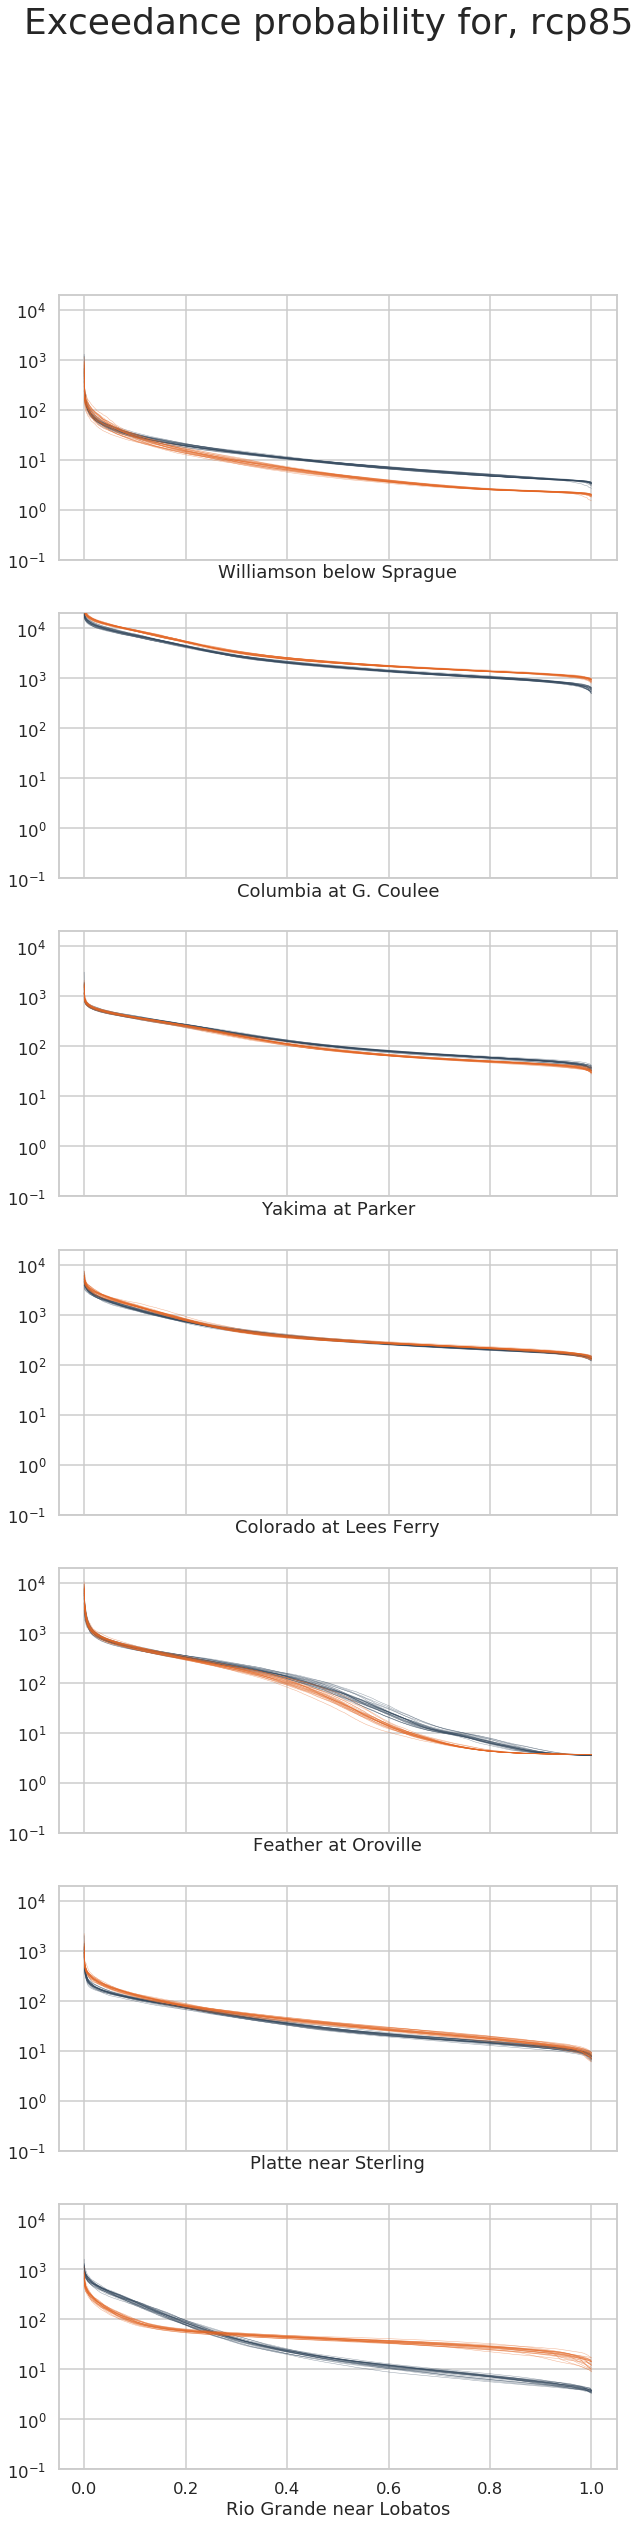

In [16]:
# MULTIPLE LOCATIONS, SINGLE COLUMN (DID NOT USE IN REPORT)
make_fig = False
if make_fig:
    
    loca_color = "#3498db"
    loca_hist_color = "#34495e"
    bcsd_color = "#e73cac"
    bcsd_hist_color = "#e46725"

    obs_color = "#3498db"
    hist_color = "#34495e"
    rcp_color = "#e74c3c"
    
    scale = 'all'  #high10, low10, all
    

#     lookup_bor = pd.read_csv(f'/glade/u/home/jvano/projects/LOCA_Downscaling_Analysis/lists/basin_evaluated_table3.csv')
    lookup_bor = pd.read_csv(f'/glade/u/home/jvano/projects/LOCA_Downscaling_Analysis/lists/basin_evaluated_table3_7.csv')
    lookup_bor = lookup_bor.set_index('Number')

#     fig, axes = plt.subplots(ncols=7, nrows=7, sharex=True, sharey=True, figsize=(80, 10), squeeze=False)
#     fig, axes = plt.subplots(ncols=6, nrows=3, sharex=True, sharey=True, figsize=(30, 10), squeeze=False)
    fig, axes = plt.subplots(ncols=1, nrows=7, sharex=True, sharey=True, figsize=(10, 40), squeeze=False)

    period = 'hist' #fut, hist, hist_fut
#     rcp = 'rcp45'
    rcp = 'rcp85'

    for i, (staid, row) in enumerate(lookup_bor.iterrows()):

        plt.sca(axes.flat[i])
        dfloca = get_loca_df_bor(row.segid)
        histloca = make_fdc_data(dfloca['1970': '1999'].filter(regex=f'{rcp}'))
        dfbcsd = get_bcsd_df_bor(row.segid, huc=None)
        histbcsd = make_fdc_data(dfbcsd['1970': '1999'].filter(regex=f'{rcp}'))
        
        if (rcp == 'rcp85'):
            rcploca = make_fdc_data(dfloca['2070': '2099'].filter(regex='rcp85'))
            rcpbcsd = make_fdc_data(dfbcsd['2070': '2099'].filter(regex='rcp85'))
            print('reading rcp85')
        if (rcp == 'rcp45'):
            rcploca = make_fdc_data(dfloca['2070': '2099'].filter(regex='rcp45'))
            rcpbcsd = make_fdc_data(dfbcsd['2070': '2099'].filter(regex='rcp45'))
            print('reading rcp45')
        if (period == 'hist'):
            lines0 = plt.plot(histloca.index, histloca.values, color=loca_hist_color, lw=0.5, alpha=0.5, zorder=10)
            lines1 = plt.plot(histbcsd.index, histbcsd.values, color=bcsd_hist_color, lw=0.5, alpha=0.5, zorder=10)
        if (period == 'fut'):
            lines2 = plt.plot(rcploca.index, rcploca.values, color=loca_color, lw=0.5, alpha=0.5)
            lines3 = plt.plot(rcpbcsd.index, rcpbcsd.values, color=bcsd_color, lw=0.5, alpha=0.5)
        if (period == 'hist_fut'):
            lines0 = plt.plot(histloca.index, histloca.values, color=loca_hist_color, lw=0.5, alpha=0.5, zorder=10)
            lines1 = plt.plot(histbcsd.index, histbcsd.values, color=bcsd_hist_color, lw=0.5, alpha=0.5, zorder=10)
            lines2 = plt.plot(rcploca.index, rcploca.values, color=loca_color, lw=0.5, alpha=0.5)
            lines3 = plt.plot(rcpbcsd.index, rcpbcsd.values, color=bcsd_color, lw=0.5, alpha=0.5)

        plt.yscale('log')
        plt.xlabel(f'{row.Name}')
        plt.ylim([.1, 20000]) 
        if (scale == 'high10'):
            plt.xlim([0, .1])
            plt.ylim([.5, 30000]) 
        if (scale == 'low10'):
            plt.xlim([0.9, 1.0])
    #     plt.figlegend((lines0[0], lines2[0]), ('Historical', 'RCP 8.5'))

    fig.suptitle(f'Exceedance probability for, {rcp}', fontsize=36)
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/fdc_ensemble_bor_{period}_{rcp}_{scale}.png', bbox_inches='tight', dpi=100)